In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [5]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset and DataLoader
train_dataset = datasets.ImageFolder(root='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [6]:
# Option 1: Use a pretrained ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)


c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.2030
Epoch 2/10, Loss: 0.1944
Epoch 3/10, Loss: 0.1738
Epoch 4/10, Loss: 0.1773
Epoch 5/10, Loss: 0.1375
Epoch 6/10, Loss: 0.1274
Epoch 7/10, Loss: 0.1120
Epoch 8/10, Loss: 0.1360
Epoch 9/10, Loss: 0.1119
Epoch 10/10, Loss: 0.1183


In [10]:
torch.save(model.state_dict(), 'cnn_model.pth')
print("Model saved as cnn_model.pth")


Model saved as cnn_model.pth


In [26]:
# Save the entire model (including architecture)
torch.save(model, 'cnn_model.pth')


In [27]:
from torch.utils.data import random_split

# Split dataset (80% train, 20% val)
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5  # Convert logits to class
            all_preds.extend(preds.astype(int).flatten())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Validation - Acc: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


[Epoch 1] Train Loss: 0.0811
Validation - Acc: 0.9220, Precision: 0.7541, Recall: 0.9787, F1: 0.8519
[Epoch 2] Train Loss: 0.0681
Validation - Acc: 0.9659, Precision: 0.9167, Recall: 0.9362, F1: 0.9263
[Epoch 3] Train Loss: 0.0561
Validation - Acc: 0.9707, Precision: 0.9184, Recall: 0.9574, F1: 0.9375
[Epoch 4] Train Loss: 0.0561
Validation - Acc: 0.9659, Precision: 0.9348, Recall: 0.9149, F1: 0.9247
[Epoch 5] Train Loss: 0.0518
Validation - Acc: 0.9659, Precision: 0.9000, Recall: 0.9574, F1: 0.9278
[Epoch 6] Train Loss: 0.0595
Validation - Acc: 0.9415, Precision: 0.8182, Recall: 0.9574, F1: 0.8824
[Epoch 7] Train Loss: 0.0769
Validation - Acc: 0.9415, Precision: 0.8182, Recall: 0.9574, F1: 0.8824
[Epoch 8] Train Loss: 0.0939
Validation - Acc: 0.9024, Precision: 0.7213, Recall: 0.9362, F1: 0.8148
[Epoch 9] Train Loss: 0.1103
Validation - Acc: 0.9122, Precision: 0.7736, Recall: 0.8723, F1: 0.8200
[Epoch 10] Train Loss: 0.0869
Validation - Acc: 0.9366, Precision: 0.8148, Recall: 0.9362, 

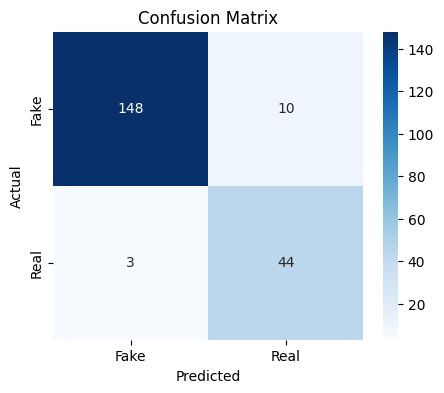

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Final Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [29]:
from sklearn.metrics import confusion_matrix

# Assuming all_preds and all_labels are your predictions and true labels
cm = confusion_matrix(all_labels, all_preds)

# Print confusion matrix in text format
print("\nConfusion Matrix (Text Format):")
print("True Positives (Real as Real)   |", cm[1, 1])
print("False Positives (Fake as Real)  |", cm[0, 1])
print("False Negatives (Real as Fake)  |", cm[1, 0])
print("True Negatives (Fake as Fake)   |", cm[0, 0])

# Optionally: You can also print the whole matrix like this
print("\nFull Confusion Matrix:")
print(cm)



Confusion Matrix (Text Format):
True Positives (Real as Real)   | 44
False Positives (Fake as Real)  | 10
False Negatives (Real as Fake)  | 3
True Negatives (Fake as Fake)   | 148

Full Confusion Matrix:
[[148  10]
 [  3  44]]


In [30]:
import torch
import torch.nn as nn
from torchvision import models

# Define the model architecture (same as during training)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Use pre-trained ResNet18
        self.model = models.resnet18(pretrained=True)
        
        # Change the final fully connected layer to match binary classification (real or fake)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # 2 classes (real/fake)

    def forward(self, x):
        return self.model(x)


In [31]:
state_dict = torch.load('cnn_model.pth')
print(state_dict.keys())


odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [59]:
import torch
from torchvision import models

# Define the model architecture (ResNet18 in this case)
model = models.resnet18(pretrained=False)

# Modify the final fully connected layer to match the number of classes (e.g., 1 class)
model.fc = torch.nn.Linear(model.fc.in_features, 1)

# Load the trained model weights (state_dict)
model.load_state_dict(torch.load('cnn_model.pth'))

# Set the model to evaluation mode
model.eval()

# Preprocess the image
from PIL import Image
from torchvision import transforms

def process_image(image_path):
    image = Image.open(image_path)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Make a prediction
image = process_image('img.jpeg')  # Replace with your image path
# image = process_image('original.png')  # Replace with your image path
with torch.no_grad():  # No need to track gradients during inference
    output = model(image)

# If it's a classification problem (1 class), we can directly output the prediction
print(f'Predicted output: {output.item()}')


Predicted output: -4.430375099182129


In [61]:
import torch

# Function to predict "Real" or "Fake" based on raw model output
def classify_output(output):
    # Check the sign of the raw output
    if output.item() >= 0:
        label = 'Real'
        probability = torch.sigmoid(output)  # Apply sigmoid for probability
    else:
        label = 'Fake'
        probability = torch.sigmoid(output)  # Apply sigmoid for probability

    # Debugging: print the output and the corresponding probability
    print(f"Raw output: {output.item()}, Probability: {probability.item()}")
    
    return label, probability.item()

# Example usage (replace with your model's raw output)
raw_output = torch.tensor([2.531982898712158])  # Replace with your model's raw output

# Call the function to get the prediction
label, probability = classify_output(raw_output)

# Print the result
print(f'Predicted label: {label} (Probability: {probability})')


Raw output: 2.531982898712158, Probability: 0.9263536930084229
Predicted label: Real (Probability: 0.9263536930084229)


In [15]:
def prediction():
    import tkinter as tk
    from tkinter import filedialog
    from PIL import Image
    import torch
    from torchvision import models, transforms

    # Function to select image and return its path
    def select_image():
        root = tk.Tk()
        root.withdraw()  # Hide the root window
        file_path = filedialog.askopenfilename(
            title="Select an image",
            filetypes=[("Image Files", "*.png *.jpg *.jpeg *.bmp *.gif")]
        )
        return file_path

    # Function to preprocess image from its path
    def transform_image(image_path):
        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        return transform(image).unsqueeze(0)  # Add batch dimension

    # Function to classify the output
    def classify_output(output):
        prob = torch.sigmoid(output)
        print(output.item())
        label = 'Real' if output.item() >= 0 else 'Fake'
        return label, prob.item()

    # Load model
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load('cnn_model.pth', map_location=torch.device('cpu')))
    model.eval()

    # Select image and process it
    image_path = select_image()
    if not image_path:
        print("No image selected.")
        return

    input_tensor = transform_image(image_path)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)

    # Interpret output
    label, probability = classify_output(output)

    # Print result
    print(f'Predicted label: {label} (Probability: {probability})')



In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image

def process_image(image_path):
    # Your custom function that does something with the image
    print("Image selected:", image_path)
    image = Image.open(image_path)
    image.show()  # Just shows the image for demonstration

def select_image():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(
        title="Select an image",
        filetypes=[("Image Files", "*.png *.jpg *.jpeg *.bmp *.gif")]
    )
    if file_path:
        process_image(file_path)

# Call this function to trigger the file dialog
select_image()


Image selected: C:/Users/shiva/Pictures/DATASET/Train/Fake/0df0d345-583b630d92fe77ec452dfa74_pan_page-1_jpg.rf.0502d1976d83c6dd582e80b9896db953.jpg


In [27]:
prediction()

-2.3929286003112793
Predicted label: Fake (Probability: 0.08371351659297943)
